<a href="https://colab.research.google.com/github/MarioCicalese/Faster-R-CNN-For-Self-Driving-Car/blob/main/Progetto_Tesi_fasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#prima di effettuare qualsiasi operazione creo il collegamento con google drive in modo da poter avere il mio dataset nel workspace di google colab
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#da adesso in poi avremo il dataset all'interno del workspace di google colab, potendolo utilizzare all'interno dei notebook
#facciamo l'unzip del dataset
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/ACDC_DATASET/ACDC_DATASET.zip', 'r') as file:
    file.extractall()

In [ ]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import json
from sklearn import preprocessing
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [ ]:
BASE_PATH = "/content/ACDC DATASET"
JSON_PATH = os.path.join(BASE_PATH, "gt_panoptic")
IMG_TRAIN_PATH = os.path.join(BASE_PATH, "train")
IMG_VAL_PATH = os.path.join(BASE_PATH, "val")

In [ ]:
New_width = 800
New_height = 600

In [ ]:
classes= {19:'traffic light',20:'traffic sign',24:'person',25:'rider',26:'car',27:'truck',
          28:'bus',31:'train',32:'motorcycle',33:'bicycle'}

In [ ]:
name_classes= {0:'traffic light',1:'traffic sign',2:'person',3:'rider',4:'car',5:'truck',
          6:'bus',7:'train',8:'motorcycle',9:'bicycle'}

In [ ]:
remove_label = [7,8,11,12,13,17,21,22,23]

In [ ]:
classes_mapped = {}
for i, key in enumerate(classes):
  classes_mapped[key] = i

print(classes_mapped)

{19: 0, 20: 1, 24: 2, 25: 3, 26: 4, 27: 5, 28: 6, 31: 7, 32: 8, 33: 9}


In [ ]:
def json_files_to_df(json_path):
  # Carica il file JSON
  with open(json_path, 'r') as f:
      data = json.load(f)

  # Estrai le informazioni relative alle bounding box e immagini
  annotations = data['annotations']

  # Lista per i dati delle bounding box
  bbox_data = []

  # Itera su ogni annotazione e associa l'immagine corrispondente
  for ann in annotations:
      image_id = ann['image_id']
      img_filename = ann['file_name']
      for bbox in ann['segments_info']:
          if bbox['category_id'] not in remove_label:
            bbox_data.append({
              'image_id': image_id,
              'filename': img_filename,
              'labels': bbox['category_id'],
              'bbox': bbox['bbox'],
              'area' : bbox['area'],
              'category_name': classes[bbox['category_id']]
            })
  # Creazione del DataFrame
  df = pd.DataFrame(bbox_data)

  # Salva in formato CSV
  df.to_csv('annotations.csv', index=False)
  return df

In [ ]:
def head_df_file(df_path,max_rows,max_colwidth):
  # Leggi il file CSV in un DataFrame
  df = pd.read_csv(df_path)
  pd.set_option('display.max_colwidth', max_colwidth)

  # Visualizza solo le prime max_rows righe
  print(df.head(max_rows))

def head_df(df,max_rows,max_colwidth):
  pd.set_option('display.max_colwidth', max_colwidth)
  print(df.head(max_rows))

In [ ]:
df_train = json_files_to_df(os.path.join(JSON_PATH,'train_gt_panoptic.json'))
df_val = json_files_to_df(os.path.join(JSON_PATH,'val_gt_panoptic.json'))

df = pd.DataFrame()
df = df.append(df_train, ignore_index=True)
df = df.append(df_val, ignore_index=True)

<ipython-input-11-2c69caaad896>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_train, ignore_index=True)
<ipython-input-11-2c69caaad896>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_val, ignore_index=True)


In [ ]:
head_df(df,100000,13)

           image_id      filename  labels          bbox    area category_name
0      GOPR0475_...  fog/train...      19  [715, 758...     149  traffic l...
1      GOPR0475_...  fog/train...      20  [886, 682...    1073  traffic sign
2      GOPR0475_...  fog/train...      26  [771, 777...     507           car
3      GOPR0475_...  fog/train...      24  [892, 771...     267        person
4      GOPR0475_...  fog/train...      26  [832, 773...     679           car
...             ...           ...     ...           ...     ...           ...
16240  GP030176_...  snow/val/...      24  [1007, 74...     470        person
16241  GP030176_...  snow/val/...      24  [0, 624, ...   30322        person
16242  GP030176_...  snow/val/...      26  [928, 753...    1071           car
16243  GP030176_...  snow/val/...      26  [847, 762...    5846           car
16244  GP030176_...  snow/val/...      31  [0, 332, ...  137052         train

[16245 rows x 6 columns]


In [ ]:
df['category_name'].value_counts()

car              8847
person           2270
traffic sign     1870
traffic light    1016
truck             659
bicycle           492
motorcycle        319
rider             280
train             268
bus               224
Name: category_name, dtype: int64

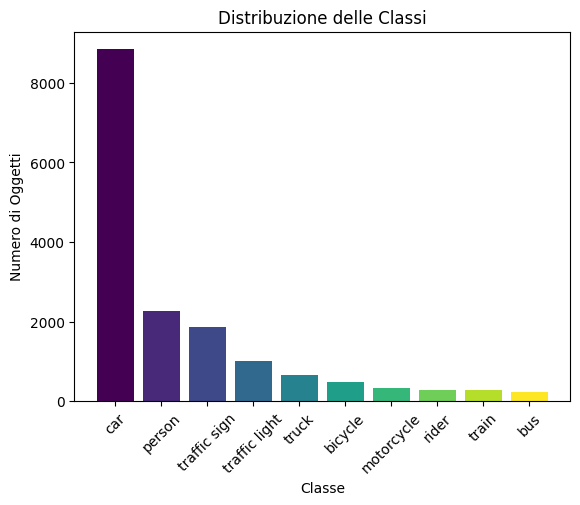

In [ ]:
conteggi_per_classe = df['category_name'].value_counts()

# Creazione di un array di colori
colori = plt.cm.viridis(np.linspace(0, 1, len(conteggi_per_classe)))

# Creazione dell'istogramma con colori differenti per ogni barra
plt.bar(conteggi_per_classe.index, conteggi_per_classe.values, color=colori)

# Aggiunta di etichette
plt.xlabel('Classe')
plt.ylabel('Numero di Oggetti')
plt.title('Distribuzione delle Classi')
plt.xticks(rotation=45)
# Mostra l'istogramma
plt.show()

In [ ]:
colori = ['#00B0F0','#61D836']
# Etichette per la legenda
etichette = ['Validation Set', 'Training Set']

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Creazione dell'istogramma
ax[0].bar(etichette,[len(df_train), len(df_val)], color=colori)

# Aggiunta di etichette
ax[0].set_xlabel('DataFrame')
ax[0].set_ylabel('Lunghezza')
ax[0].set_title('Confronto della Lunghezza dei Set')


# Calcolo della differenza percentuale tra le lunghezze
differenza_percentuale = ((len(df_train) - len(df_val)) / len(df_train)) * 1
# Dati per il grafico a torta
dati_torta = [len(df_train), len(df_val)]

# Creazione del grafico a torta
ax[1].pie(dati_torta, labels=etichette, startangle=140, colors=colori)

# Aggiunta del titolo
ax[1].set_title('Differenza della grandezza dei set')

# Mostra il grafico a torta
plt.show()

NameError: ignored

In [ ]:
def coco_to_faster_rcnn(bbox):
    xmin, ymin, width, height = bbox
    xmax = xmin + width
    ymax = ymin + height
    return [xmin, ymin, xmax, ymax]

def classes_mapped_method(old_id):
  return classes_mapped[old_id]

def resize_bbox(bbox, original_width, original_height, new_width, new_height):
  xmin, ymin, xmax, ymax = bbox
  # Calcola i rapporti di ridimensionamento
  width_ratio = new_width / original_width
  height_ratio = new_height / original_height
  # Ridimensiona le coordinate
  new_xmin = xmin * width_ratio
  new_ymin = ymin * height_ratio
  new_xmax = xmax * width_ratio
  new_ymax = ymax * height_ratio
  return [new_xmin, new_ymin, new_xmax, new_ymax]

df['bbox'] = df['bbox'].apply(coco_to_faster_rcnn)
df['labels'] = df['labels'].apply(classes_mapped_method)
df['bbox'] = df['bbox'].apply(resize_bbox,args=(1920,1080,New_width,New_height))

In [ ]:
# bounding box coordinates point need to be in separate columns
df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['bbox'][i] for i in range(len(df['bbox'])))

df.drop(columns=['bbox'], inplace=True)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
head_df(df,1000000,20)

                  image_id             filename  labels    area  \
0      GOPR0475_frame_0...  fog/train/GOPR04...       0     149   
1      GOPR0475_frame_0...  fog/train/GOPR04...       1    1073   
2      GOPR0475_frame_0...  fog/train/GOPR04...       4     507   
3      GOPR0475_frame_0...  fog/train/GOPR04...       2     267   
4      GOPR0475_frame_0...  fog/train/GOPR04...       4     679   
...                    ...                  ...     ...     ...   
16240  GP030176_frame_0...  snow/val/GP03017...       2     470   
16241  GP030176_frame_0...  snow/val/GP03017...       2   30322   
16242  GP030176_frame_0...  snow/val/GP03017...       4    1071   
16243  GP030176_frame_0...  snow/val/GP03017...       4    5846   
16244  GP030176_frame_0...  snow/val/GP03017...       7  137052   

       category_name        xmin        ymin        xmax        ymax  
0      traffic light  297.916667  421.111111  337.916667  428.888889  
1       traffic sign  369.166667  378.888889  457.083

In [ ]:
print(len(df_train['image_id'].unique()),"immagini di training")
print(len(df_val['image_id'].unique()), "immagini di validation")

1599 immagini di training
405 immagini di validation


In [ ]:
valid_ids = df_val['image_id'].unique()
train_ids = df_train['image_id'].unique()

print(len(train_ids))
print(len(valid_ids))

1599
405


In [ ]:
df_val = df[df['image_id'].isin(valid_ids)]
df_train = df[df['image_id'].isin(train_ids)]
df_val_piccolo = df_val[:100]
df_val.shape, df_train.shape


((3445, 9), (12800, 9))

In [ ]:
class AcdcDataset(Dataset):

  def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

  def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}_rgb_anon.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.resize(image,(800,600))
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)

            return image, target


  def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = AcdcDataset(df_train,IMG_TRAIN_PATH,get_transform_train())
valid_dataset = AcdcDataset(df_val,IMG_VAL_PATH,get_transform_valid())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

In [ ]:
# Verifica la disponibilità della GPU
if torch.cuda.is_available():
    # Utilizza la GPU
    device = torch.device("cuda")
else:
    # Utilizza la CPU
    device = torch.device("cpu")

print("Dispositivo in uso:", device)

Dispositivo in uso: cuda


ValueError: ignored

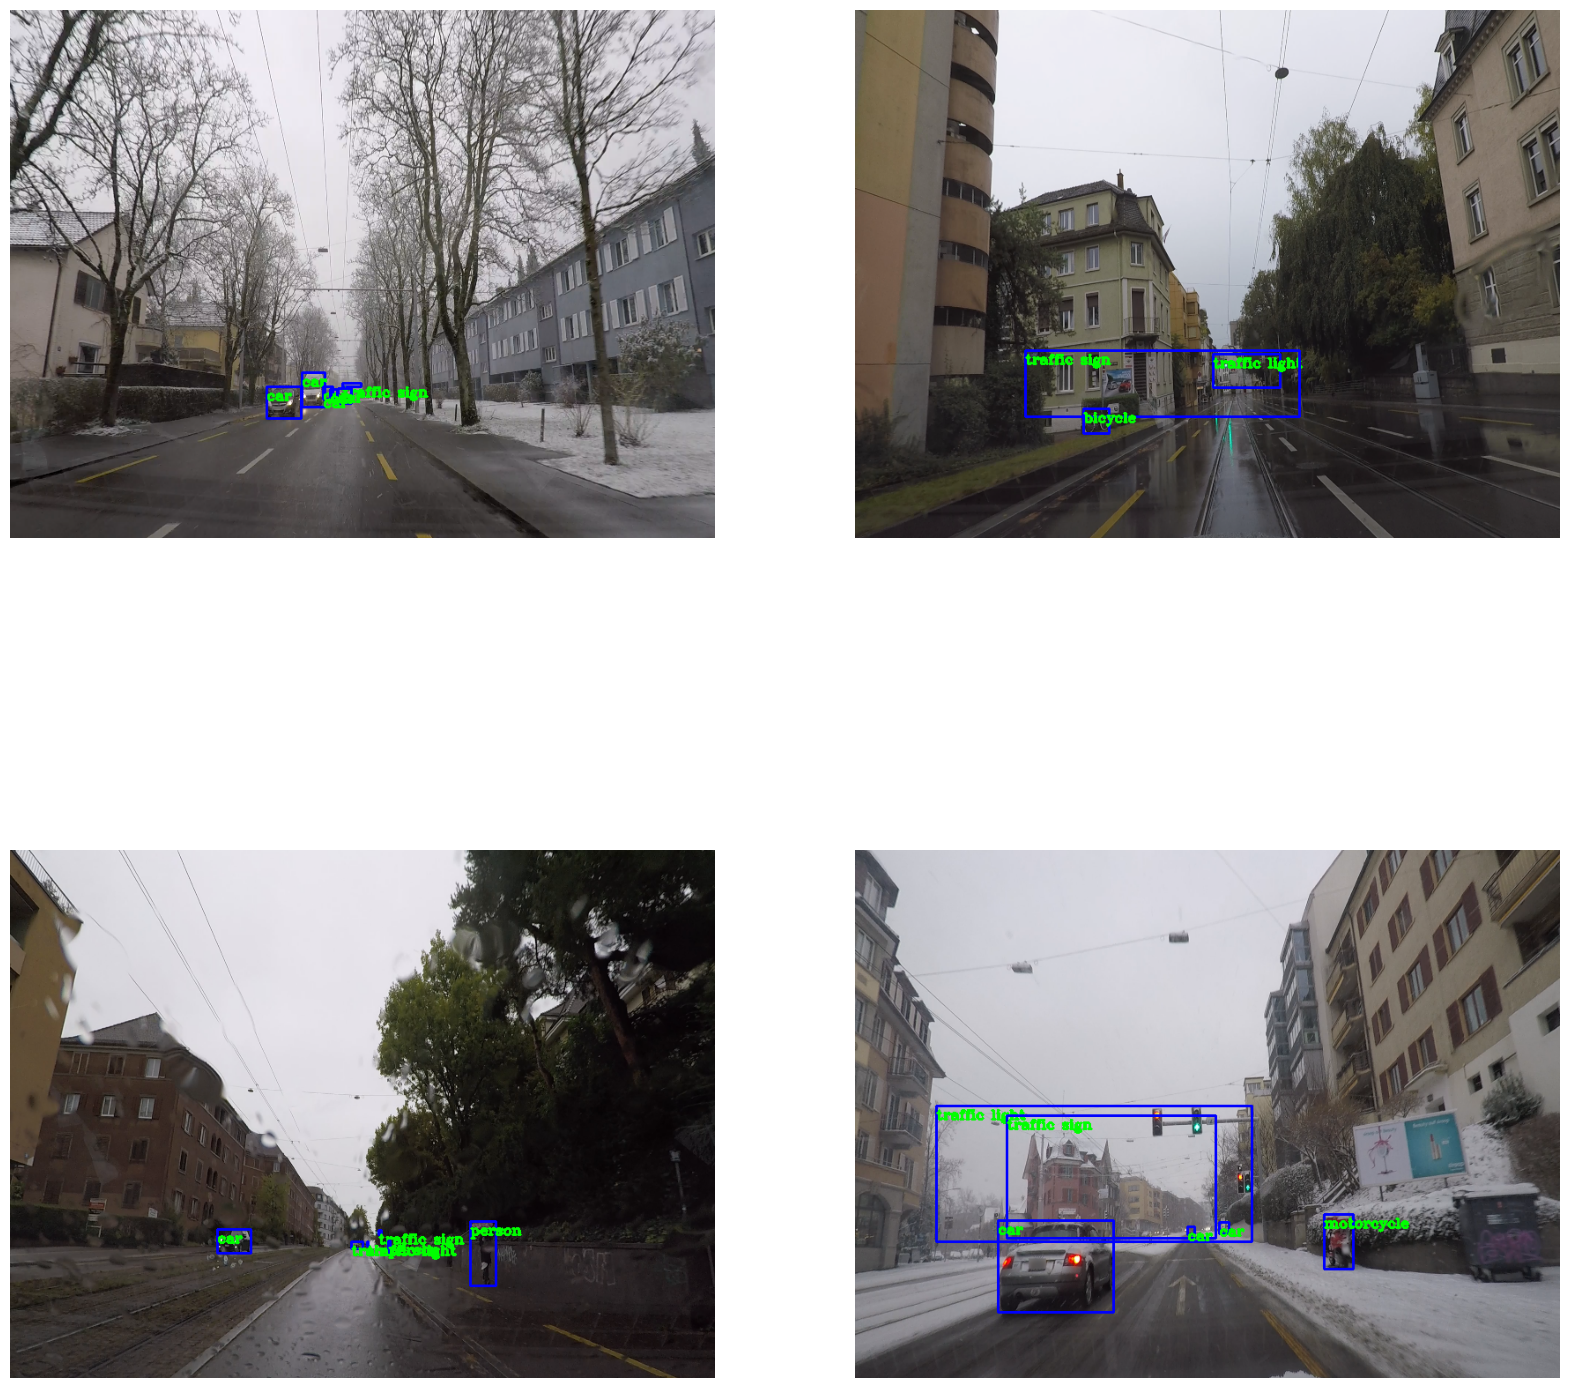

In [ ]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, name_classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),2,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample,vmin=0,vmax=1)

In [ ]:

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
#torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 46.4MB/s]


In [ ]:
num_classes = 10

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-v6lwvwb1
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-v6lwvwb1
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=379039 sha256=9a72557c53785db5af65b920fa5f0879ffd9c80ffe9796cc0e705784b80ac8c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-fhf_d4pz/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


In [ ]:
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 409650, done.
remote: Counting objects: 100% (18573/18573), done.
remote: Compressing objects: 100% (1744/1744), done.
remote: Total 409650 (delta 17933), reused 16954 (delta 16826), pack-reused 391077
Receiving objects: 100% (409650/409650), 788.59 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (380416/380416), done.


In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
def calculate_iou(box1, box2):
    # Calcola l'area dell'intersezione
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calcola l'area delle bounding boxes
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calcola l'Union over Union (IoU)
    iou = intersection_area / (area_box1 + area_box2 - intersection_area)

    return iou


def calculate_recall(ground_truth_boxes, predicted_boxes, iou_threshold):
    num_ground_truth = len(ground_truth_boxes)
    num_predicted = len(predicted_boxes)
    true_positives = 0

    if num_ground_truth == 0:
        if num_predicted == 0:
            return 1.0
        else:
            return 0.0

    for gt_box in ground_truth_boxes:
        iou_with_pred = [calculate_iou(gt_box, pred_box) for pred_box in predicted_boxes]

        if iou_with_pred and max(iou_with_pred) >= iou_threshold:
            true_positives += 1

    recall = true_positives / num_ground_truth if num_ground_truth > 0 else 0.0
    return recall

def compute_AP_for_class_id(class_id, gt_boxes, gt_labels, pred_boxes, pred_labels, pred_scores, iou_threshold=0.5):
    # Filtra le bounding boxes e le labels per la classe corrente
    class_gt_indices = [i for i, label in enumerate(gt_labels) if label == class_id]
    class_pred_indices = [i for i, label in enumerate(pred_labels) if label == class_id]

    class_gt_boxes = [gt_boxes[i] for i in class_gt_indices]
    class_pred_boxes = [pred_boxes[i] for i in class_pred_indices]
    class_pred_scores = [pred_scores[i] for i in class_pred_indices]
    if not class_pred_scores:
      return 0.0

    y_true = []
    y_scores = []

    # Per ogni predizione, verifica se c'è una corrispondenza con le gt_boxes
    for pred_box, score in zip(class_pred_boxes, class_pred_scores):
        max_iou = 0
        for gt_box in class_gt_boxes:
            iou = calculate_iou(pred_box, gt_box)
            max_iou = max(max_iou, iou)

        y_scores.append(score)
        if max_iou >= iou_threshold:
            y_true.append(1)
        else:
            y_true.append(0)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Calcola l'AP usando sklearn
    AP = average_precision_score(y_true, y_scores)
    if AP == -0.0:
      AP = 0.0
    return AP

def calculate_metrics(gt_boxes, gt_labels, pred_boxes, pred_labels, pred_scores, iou_threshold=0.5, conf_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0

    # Filtra le bounding boxes in base alla soglia di confidenza
    filtered_pred_boxes = [box for i, box in enumerate(pred_boxes) if pred_scores[i] >= conf_threshold]
    filtered_pred_labels = [label for i, label in enumerate(pred_labels) if pred_scores[i] >= conf_threshold]

    for true_box, true_label in zip(gt_boxes, gt_labels):
        matched = False
        for pred_box, pred_label in zip(filtered_pred_boxes, filtered_pred_labels):
            if true_label == pred_label and calculate_iou(true_box, pred_box) >= iou_threshold:
                tp += 1
                matched = True
                break

        if not matched:
            fn += 1

    fp = len(filtered_pred_boxes) - tp

    return tp, fp, fn

In [ ]:
def evaluate_model(model, data_loader, iou_threshold=0.5, conf_threshold=0.5):
    model.eval()  # Imposta il modello in modalità valutazione
    total_recall = 0.0
    iou_values = []
    average_ious = []
    num_samples = len(data_loader.dataset)
    all_pred_boxes = []
    all_pred_labels = []
    all_gt_boxes = []
    all_gt_labels = []
    all_pred_scores = []
    total_tp = 0
    total_fp = 0
    total_fn = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)  # Ottieni le predizioni del modello

            for target, output in zip(targets, outputs):
                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()
                pred_boxes = output['boxes'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                filtered_pred_boxes = [box for i, box in enumerate(pred_boxes) if pred_scores[i] >= conf_threshold]
                filtered_pred_labels = [label for i, label in enumerate(pred_labels) if pred_scores[i] >= conf_threshold]
                all_pred_boxes.extend(output['boxes'].cpu().numpy())
                all_pred_labels.extend(output['labels'].cpu().numpy())
                all_gt_boxes.extend(target['boxes'].cpu().numpy())
                all_gt_labels.extend(target['labels'].cpu().numpy())
                all_pred_scores.extend(output['scores'].cpu().numpy())

                tp, fp, fn = calculate_metrics(gt_boxes, gt_labels, pred_boxes, pred_labels,pred_scores)
                total_tp += tp
                total_fp += fp
                total_fn += fn

                # Calcola la recall per questa immagine
                recall = calculate_recall(gt_boxes, filtered_pred_boxes, iou_threshold)
                total_recall += recall

                # Calcola l'IoU per ciascuna bounding box predetta in questa immagine
                for pred_box in filtered_pred_boxes:
                  iou_per_box = []  # Lista per memorizzare gli IoU per questa bounding box predetta
                  for true_box in gt_boxes:
                    iou_value = calculate_iou(pred_box, true_box)
                    iou_per_box.append(iou_value)
                  # Trova il massimo IoU per questa bounding box predetta
                  max_iou_for_pred_box = max(iou_per_box)
                  iou_values.append(max_iou_for_pred_box)
    mAP=0
    for class_id in range(num_classes):
      mAP += compute_AP_for_class_id(class_id, all_gt_boxes, all_gt_labels, all_pred_boxes, all_pred_labels, all_pred_scores)

    mAP /= num_classes
    average_recall = total_recall / num_samples
    average_iou_for_image = sum(iou_values) / len(iou_values)
    average_ious.append(average_iou_for_image)
    print("Average IoUs:", average_ious[0])
    print("Average Recall :",average_recall)
    print(f"Mean Average Precision (mAP) across all classes: {mAP}")
    print("True Positives:", total_tp)
    print("False Positives:", total_fp)
    print("False Negatives:", total_fn)

In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()

Epoch: [0]  [  0/200]  eta: 0:48:29  lr: 0.000030  loss: 3.4894 (3.4894)  loss_classifier: 2.2632 (2.2632)  loss_box_reg: 0.4173 (0.4173)  loss_objectness: 0.5505 (0.5505)  loss_rpn_box_reg: 0.2584 (0.2584)  time: 14.5467  data: 1.1696  max mem: 13125
Epoch: [0]  [ 10/200]  eta: 0:13:08  lr: 0.000281  loss: 3.5048 (3.4396)  loss_classifier: 2.2503 (2.2298)  loss_box_reg: 0.4807 (0.4957)  loss_objectness: 0.3683 (0.4125)  loss_rpn_box_reg: 0.2667 (0.3016)  time: 4.1521  data: 0.1455  max mem: 13125
Epoch: [0]  [ 20/200]  eta: 0:11:02  lr: 0.000532  loss: 3.5048 (3.4590)  loss_classifier: 2.1064 (2.1157)  loss_box_reg: 0.4783 (0.4862)  loss_objectness: 0.3643 (0.4819)  loss_rpn_box_reg: 0.3444 (0.3753)  time: 3.1358  data: 0.0407  max mem: 13125
Epoch: [0]  [ 30/200]  eta: 0:10:03  lr: 0.000783  loss: 2.9898 (3.2613)  loss_classifier: 1.7966 (1.9458)  loss_box_reg: 0.4937 (0.4911)  loss_objectness: 0.3363 (0.4588)  loss_rpn_box_reg: 0.3237 (0.3656)  time: 3.2172  data: 0.0379  max mem: 1

In [ ]:
evaluate_model(model, valid_data_loader,0.5)

Average IoUs: 0.6006365557553008
Average Recall : 0.5304457145588672
Mean Average Precision (mAP) across all classes: 0.45106802698288206
True Positives: 1779
False Positives: 1103
False Negatives: 1666


In [ ]:
model_save_name = 'resnet50v2.pt'
path = F"/content/drive/MyDrive/{model_save_name}"
torch.save(model.state_dict(), path)

In [ ]:
# Definisci il percorso di destinazione (modifica con il tuo percorso)
desktop_path = r"C:\Users\mario\Desktop"

# Definisci il percorso completo per il file del modello (modifica con il tuo nome file)
model_path = os.path.join(desktop_path, "classifier.pt")

# Ora puoi salvare il modello nel percorso specificato
torch.save(model.state_dict(), model_path)

In [ ]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
#torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
#torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

model_save_name = 'resnet50.pt'
WEIGHTS_FILE = F"/content/drive/My Drive/{model_save_name}"

num_classes = 10

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
if torch.cuda.is_available():
    # Utilizza la GPU
    model.load_state_dict(torch.load(WEIGHTS_FILE))
    model = model.to(device)
else:
    # Utilizza la CPU
    model.load_state_dict(torch.load(WEIGHTS_FILE,map_location=torch.device('cpu')))



In [ ]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

    img = cv2.resize(img,(800,600))
    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)

    model.eval()

    detection_threshold = 0.70

    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()

    return names, boxes, sample

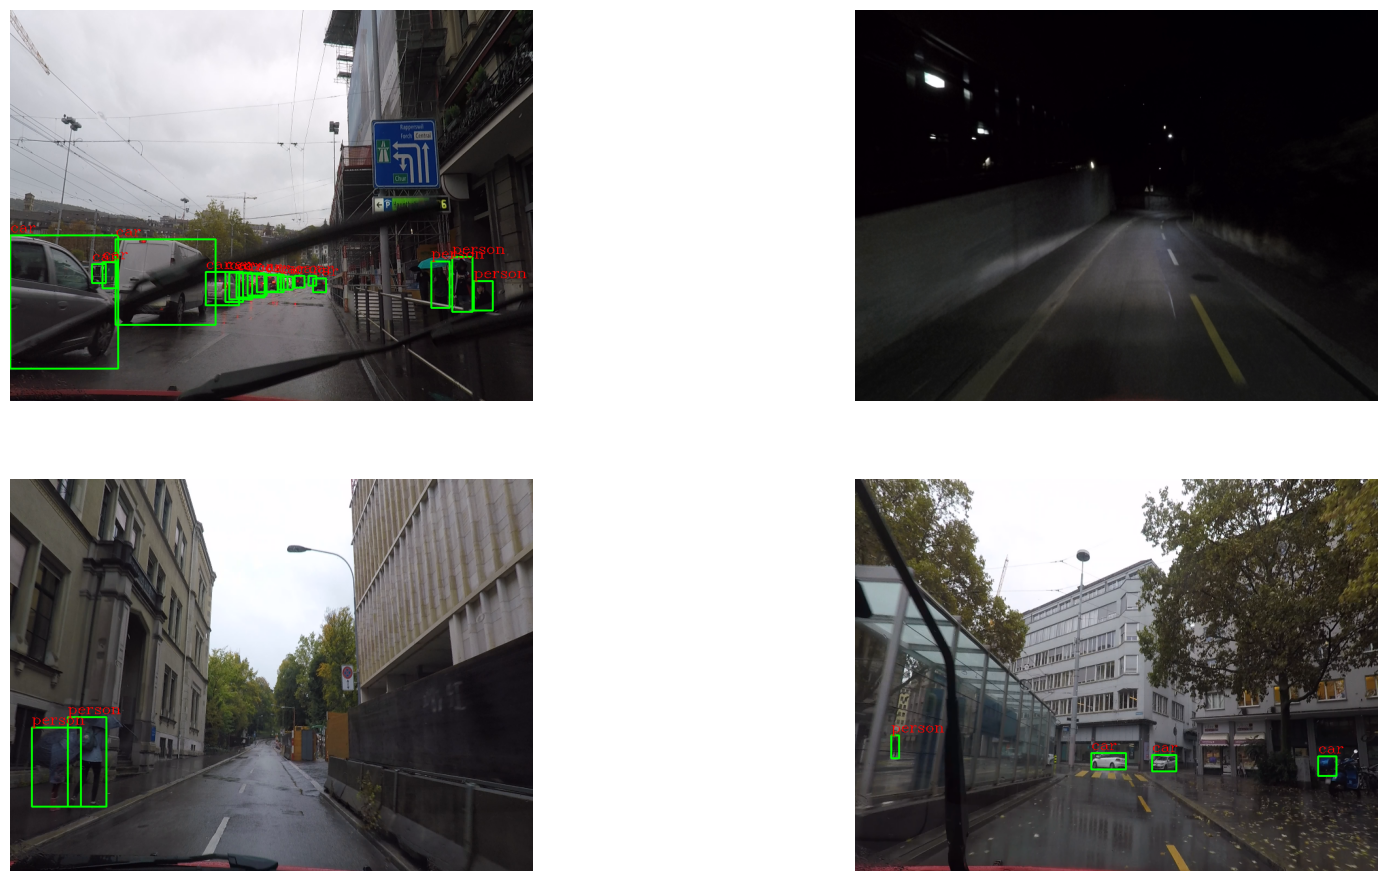

In [ ]:
test_path = os.path.join(BASE_PATH, "test")
test_files = [os.path.join(test_path,f) for f in os.listdir(test_path)]

testt = test_files[:4]
plt.figure(figsize=(20,60))
for i, images in enumerate(testt):
  plt.subplot(10,2,i+1)
  names,boxes,sample = obj_detector(images)
  for i,box in enumerate(boxes):
    cv2.rectangle(sample,
      (box[0], box[1]),
      (box[2], box[3]),
      (0, 220, 0), 2)
    cv2.putText(sample, name_classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)

  plt.axis('off')
  plt.imshow(sample)